<a href="https://colab.research.google.com/github/swastikcodes-at-git/Swastik-Das/blob/main/IDEAS_TIH_FASAL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **RANDOM** **FOREST**

In [ ]:
# === Part 1: Actual vs Predicted Yields for 2022 ===

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

file1="/content/merged_wheat_reservoir.csv"
file2="/content/merged_gram_reservoir.csv"
file3="/content/merged_massor_reservoir.csv"
file4="/content/merged_potato_reservoir.csv"
file5="/content/merged_rabi_rice_reservoir.csv"
file6="/content/merged_mustard_reservoir.csv"
df = pd.read_csv(file1)

df['temperature_recorded_date'] = pd.to_datetime(df['temperature_recorded_date'])
df['year'] = df['temperature_recorded_date'].dt.year
df['month'] = df['temperature_recorded_date'].dt.month
df['day'] = df['temperature_recorded_date'].dt.day

features_base = [
    'state_temperature_max_val',
    'state_temperature_min_val',
    'state_rainfall_val',
    'Level',
    'Current Live Storage'
]
target = 'yield'

df_clean = df.dropna(subset=features_base + [target, 'state_name'])
df_clean = df_clean.sort_values(by='temperature_recorded_date')

df_clean['lag1'] = df_clean.groupby('state_name')['yield'].shift(1)
df_clean['rolling_mean_7'] = df_clean.groupby('state_name')['yield'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)

df_final = df_clean.dropna(subset=['lag1', 'rolling_mean_7'])
features = features_base + ['month', 'day', 'lag1', 'rolling_mean_7']

min_records_threshold = 50
eligible_states = df_final['state_name'].value_counts()
eligible_states = eligible_states[eligible_states >= min_records_threshold].index.tolist()

state_rmse = {}
yield_comparison = {}

for state in eligible_states:
    state_data = df_final[df_final['state_name'] == state]
    train_data = state_data[state_data['year'] < 2022]
    test_data = state_data[state_data['year'] == 2022]

    if train_data.empty or test_data.empty:
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    state_rmse[state] = rmse

    comparison_df = test_data[['year']].copy()
    comparison_df['Actual Yield'] = y_test.values
    comparison_df['Predicted Yield'] = y_pred
    comparison_df = comparison_df.groupby('year').mean().reset_index()
    yield_comparison[state] = comparison_df

results = []

for state in sorted(yield_comparison.keys()):
    row = yield_comparison[state]
    year = int(row['year'].values[0])
    actual_yield = row['Actual Yield'].values[0]
    predicted_yield = row['Predicted Yield'].values[0]
    rmse = state_rmse[state]
    results.append({
        'state': state,
        'year': year,
        'actual_yield': actual_yield,
        'predicted_yield': predicted_yield,
        'rmse': rmse
    })

results_df = pd.DataFrame(results)
results_df.set_index(['state', 'year'], inplace=True)
results_df.sort_index(inplace=True)

print("\nPredicted vs Actual Yields (2022):\n")
print(results_df)

print("\nAverage RMSE per State:\n")
print(results_df['rmse'].sort_values())

# === Part 2: Predict Yield for 2023 ===

from sklearn.preprocessing import LabelEncoder

#df = pd.read_csv(file6)
df['temperature_recorded_date'] = pd.to_datetime(df['temperature_recorded_date'])
df['year'] = df['temperature_recorded_date'].dt.year
df['month'] = df['temperature_recorded_date'].dt.month
df['day'] = df['temperature_recorded_date'].dt.day

le = LabelEncoder()
df['state_code'] = le.fit_transform(df['state_name'])

df = df.dropna(subset=features_base + [target, 'state_name'])

df = df.sort_values(by=['state_name', 'temperature_recorded_date'])
df['lag1'] = df.groupby('state_name')[target].shift(1)
df['rolling_mean_7'] = df.groupby('state_name')[target].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)
df_final = df.dropna(subset=['lag1', 'rolling_mean_7'])

eligible_states = df_final['state_name'].value_counts()
eligible_states = eligible_states[eligible_states >= min_records_threshold].index.tolist()

features_for_monthly = ['year', 'month', 'state_code']
predicted_2023 = []

for target_col in features_base:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    df_train = df[df['year'] <= 2022].dropna(subset=[target_col])
    X = df_train[features_for_monthly]
    y = df_train[target_col]
    model.fit(X, y)

    state_codes = df['state_code'].unique()
    months = list(range(1, 13))
    pred_rows = pd.DataFrame([
        {'year': 2023, 'month': m, 'state_code': s}
        for s in state_codes for m in months
    ])
    preds = model.predict(pred_rows)
    pred_rows[target_col] = preds
    predicted_2023.append(pred_rows)

df_2023_features = predicted_2023[0]
for df_feat in predicted_2023[1:]:
    df_2023_features = df_2023_features.merge(df_feat, on=['year', 'month', 'state_code'])

df_2023_features['state_name'] = le.inverse_transform(df_2023_features['state_code'])

df_2023_state_avg = df_2023_features.groupby('state_name')[features_base].mean().reset_index()
df_2023_state_avg['year'] = 2023
df_2023_state_avg['month'] = 6
df_2023_state_avg['day'] = 15

yield_predictions = []

for state in eligible_states:
    state_data = df_final[df_final['state_name'] == state]
    train_data = state_data[state_data['year'] <= 2022]

    if train_data.empty:
        continue

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = train_data[features]
    y_train = train_data[target]
    model.fit(X_train, y_train)

    test_row = df_2023_state_avg[df_2023_state_avg['state_name'] == state].copy()
    if test_row.empty:
        continue

    train_sorted = train_data.sort_values(by='temperature_recorded_date')
    last_3_years_data = train_sorted[train_sorted['year'].isin([2020, 2021, 2022])]
    lag1_value = last_3_years_data['yield'].mean()
    rolling_mean_value = (
        train_sorted.groupby('state_name')['yield']
        .rolling(window=7, min_periods=1).mean()
        .reset_index(level=0, drop=True)
        .iloc[-50:]
        .mean()
    )

    test_row['lag1'] = lag1_value
    test_row['rolling_mean_7'] = rolling_mean_value

    X_test = test_row[features]
    predicted_yield = model.predict(X_test)[0]
    yield_predictions.append({
        'state_name': state,
        'predicted_yield_2023': predicted_yield
    })

df_yield_2023 = pd.DataFrame(yield_predictions).sort_values(by='predicted_yield_2023', ascending=False)
print("\nPredicted Yield for 2023:\n")
print(df_yield_2023.to_string(index=False))





Predicted vs Actual Yields (2022):

                     actual_yield  predicted_yield      rmse
state          year                                         
Chhattisgarh   2022       2.01897         0.403480  1.615490
Jharkhand      2022       0.81539         0.828333  0.013293
Madhya Pradesh 2022       1.14960         1.164702  0.015272
Rajasthan      2022       1.37483         1.375151  0.002865
Uttar Pradesh  2022       0.94985         0.944470  0.005380
Uttarakhand    2022       0.92518         0.952582  0.028627
West Bengal    2022       0.95965         0.959696  0.010850

Average RMSE per State:

state           year
Rajasthan       2022    0.002865
Uttar Pradesh   2022    0.005380
West Bengal     2022    0.010850
Jharkhand       2022    0.013293
Madhya Pradesh  2022    0.015272
Uttarakhand     2022    0.028627
Chhattisgarh    2022    1.615490
Name: rmse, dtype: float64

Predicted Yield for 2023:

    state_name  predicted_yield_2023
  Chhattisgarh              1.405133
     Ra

# **RF_Plots**

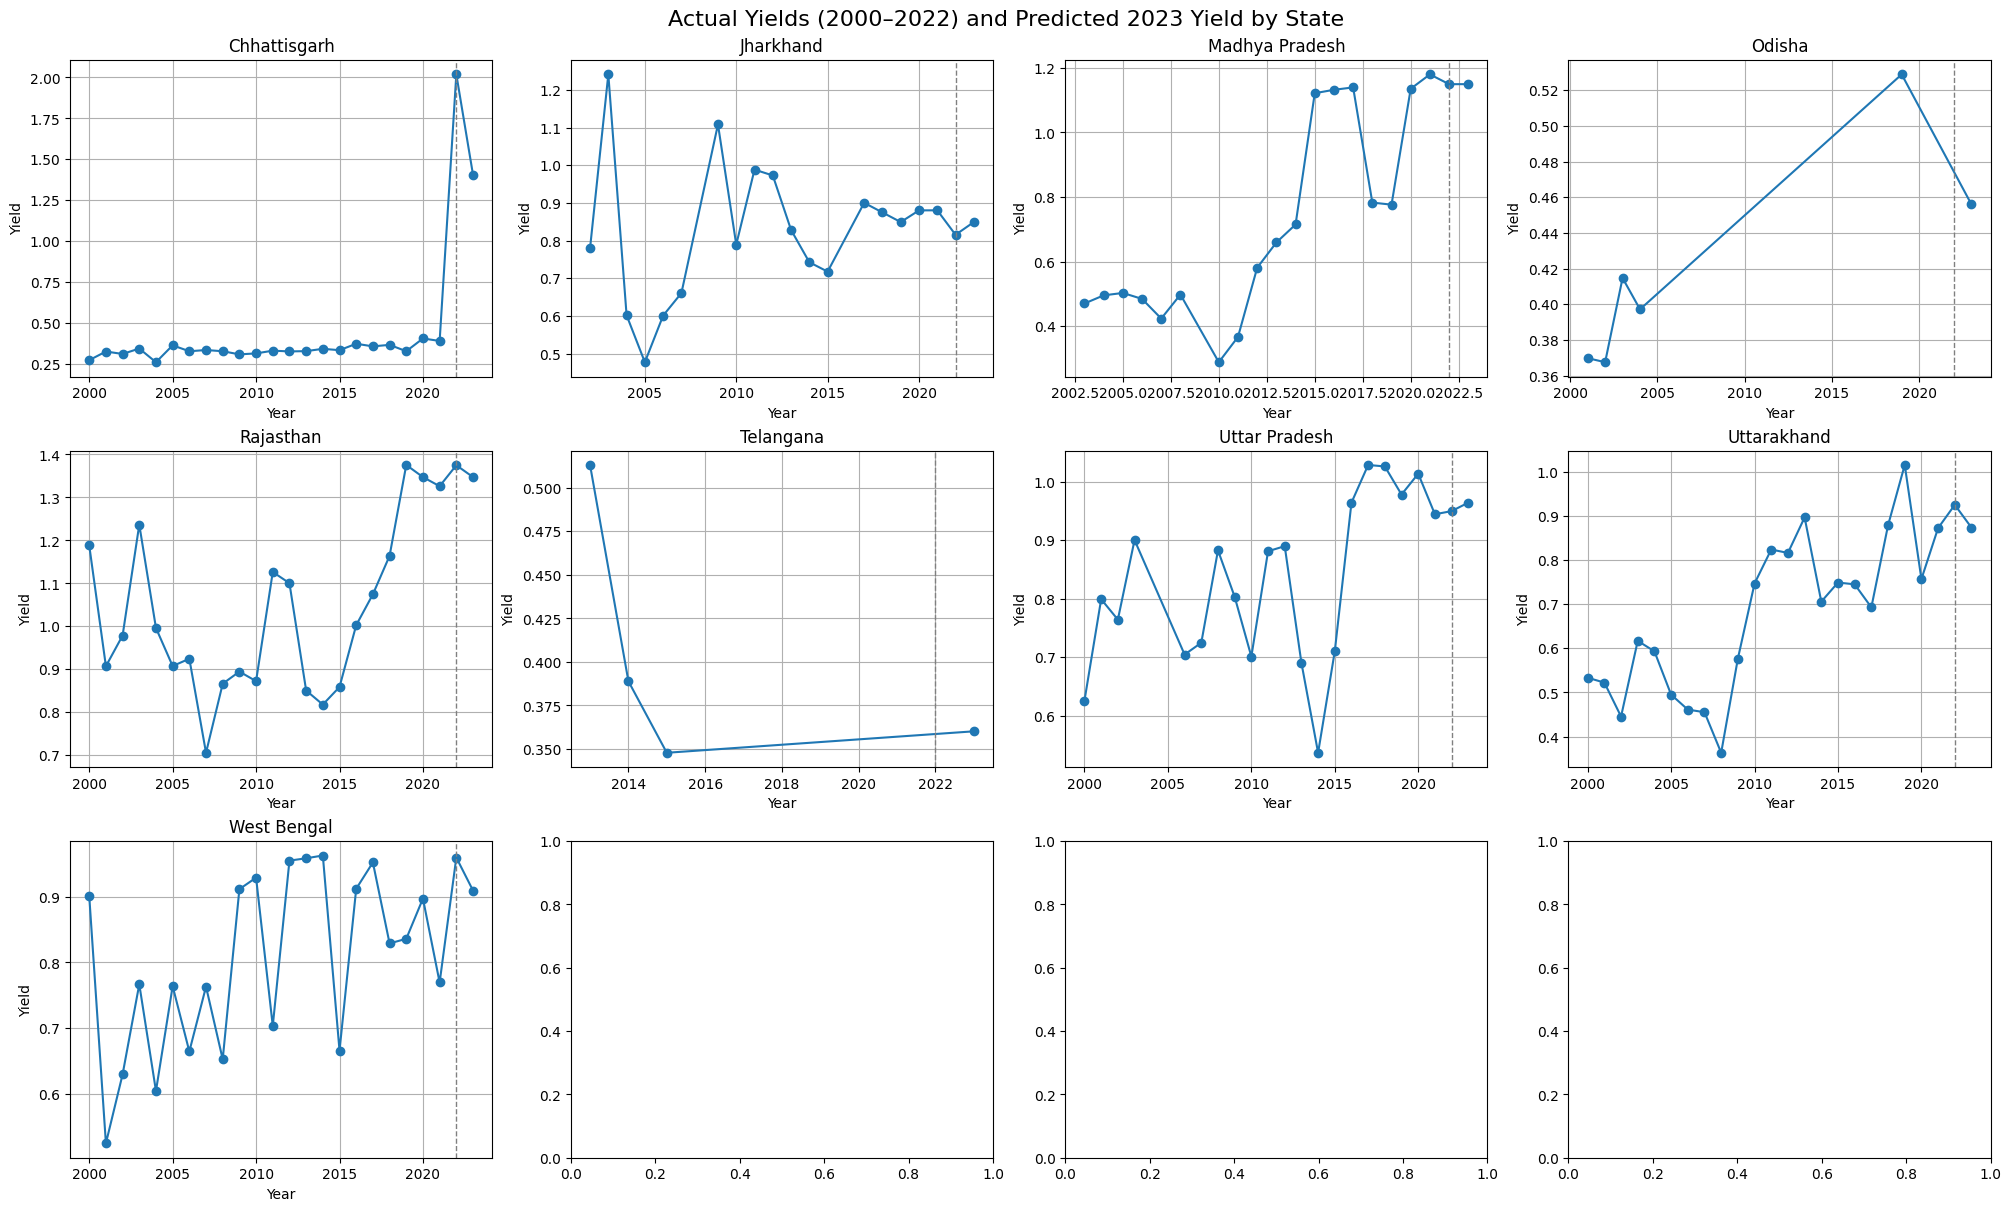

In [ ]:
# === Part 3: Plot All States (2000–2023) ===

# Combine past actuals + 2023 prediction
plot_df = df_final[df_final['state_name'].isin(eligible_states)]
plot_df_grouped = plot_df.groupby(['state_name', 'year'])['yield'].mean().reset_index()

pred_2023_df = df_yield_2023.rename(columns={'state_name': 'state_name', 'predicted_yield_2023': 'yield'})
pred_2023_df['year'] = 2023
combined_df = pd.concat([plot_df_grouped, pred_2023_df[['state_name', 'year', 'yield']]], ignore_index=True)

states = sorted(combined_df['state_name'].unique())
n_states = len(states)
n_cols = 4
n_rows = (n_states + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)

for i, state in enumerate(states):
    row, col = divmod(i, n_cols)
    ax = axs[row][col] if n_rows > 1 else axs[col]
    state_data = combined_df[combined_df['state_name'] == state]
    ax.plot(state_data['year'], state_data['yield'], marker='o', label='Yield')
    ax.axvline(2022, color='gray', linestyle='--', linewidth=1)
    ax.set_title(state)
    ax.set_xlabel("Year")
    ax.set_ylabel("Yield")
    ax.grid(True)

plt.suptitle("Actual Yields (2000–2022) and Predicted 2023 Yield by State", fontsize=16)
plt.show()


# **XGBoost**

In [ ]:
# ==============================
# 1. Load and Preprocess Monthly Data
# ==============================

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load dataset
file1="/content/merged_wheat_reservoir.csv"
file2="/content/merged_gram_reservoir.csv"
file3="/content/merged_massor_reservoir.csv"
file4="/content/merged_potato_reservoir.csv"
file5="/content/merged_rabi_rice_reservoir.csv"
file6="/content/merged_mustard_reservoir.csv"
df = pd.read_csv(file1)

# Date conversion
df['temperature_recorded_date'] = pd.to_datetime(df['temperature_recorded_date'])
df['year'] = df['temperature_recorded_date'].dt.year
df['month'] = df['temperature_recorded_date'].dt.month

# Fill missing values in exogenous variables
exog_vars = ['Level', 'Current Live Storage']
df[exog_vars] = df.groupby('state_name')[exog_vars].transform(lambda g: g.ffill().bfill())

# ==============================
# 2. Train Monthly Models to Forecast 2023 Variables
# ==============================

monthly_targets = ['state_temperature_max_val', 'state_temperature_min_val',
                   'state_rainfall_val', 'Level', 'Current Live Storage']

forecasted_rows = []

for state in df['state_name'].unique():
    state_df = df[df['state_name'] == state].copy()

    for target in monthly_targets:
        for month in range(1, 13):
            temp_df = state_df[state_df['month'] == month]
            if temp_df['year'].nunique() < 4:
                continue

            train_df = temp_df[temp_df['year'] < 2023]
            test_df = pd.DataFrame({
                'year': [2023],
                'month': [month],
                'state_name': [state]
            })

            X_train = train_df[['year']]
            y_train = train_df[target]
            X_test = test_df[['year']]

            model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)[0]

            forecasted_rows.append({
                'state_name': state,
                'year': 2023,
                'month': month,
                target: pred
            })

# Convert forecasted monthly data to DataFrame
forecast_df = pd.DataFrame(forecasted_rows)

# Pivot to reshape into one row per state-month
forecast_df = forecast_df.groupby(['state_name', 'year', 'month']).first().reset_index()

# ==============================
# 3. Aggregate Forecasted Monthly Data to Annual (2023)
# ==============================

yearly_agg = forecast_df.groupby(['state_name', 'year']).agg({
    'state_temperature_max_val': 'mean',
    'state_temperature_min_val': 'mean',
    'state_rainfall_val': 'sum',
    'Level': 'mean',
    'Current Live Storage': 'mean'
}).reset_index()

# Add dummy yield for 2023 (will not be used for training)
yearly_agg['yield'] = np.nan

# ==============================
# 4. Combine Historical Annual Data with Forecasted 2023 Data
# ==============================

# Aggregate historical data
agg_funcs = {
    'state_temperature_max_val': 'mean',
    'state_temperature_min_val': 'mean',
    'state_rainfall_val': 'sum',
    'yield': 'mean',
    'Level': 'mean',
    'Current Live Storage': 'mean'
}
annual_df = df.groupby(['state_name', 'year']).agg(agg_funcs).reset_index()

# Combine with forecasted 2023 data
full_annual_df = pd.concat([annual_df, yearly_agg], ignore_index=True)

# ==============================
# 5. Feature Engineering: Lag, Rolling, Interactions
# ==============================

features_to_lag = ['state_temperature_max_val', 'state_temperature_min_val',
                   'state_rainfall_val', 'Level', 'Current Live Storage']

for feature in features_to_lag:
    full_annual_df[f'{feature}_lag1'] = full_annual_df.groupby('state_name')[feature].shift(1)
    full_annual_df[f'{feature}_lag2'] = full_annual_df.groupby('state_name')[feature].shift(2)
    full_annual_df[f'{feature}_lag3'] = full_annual_df.groupby('state_name')[feature].shift(3)
    full_annual_df[f'{feature}_roll3'] = full_annual_df.groupby('state_name')[feature].transform(lambda x: x.shift(1).rolling(3).mean())

# Interaction and trend feature
full_annual_df['temp_rainfall_interaction'] = (
    (full_annual_df['state_temperature_max_val'] + full_annual_df['state_temperature_min_val']) / 2
) * full_annual_df['state_rainfall_val']
full_annual_df['year_feature'] = full_annual_df['year']

# ==============================
# 6. Predict Yield for 2022 (with RMSE) and 2023 (Forecast)
# ==============================

model_df = full_annual_df.dropna(subset=['yield'])
results = []

target = 'yield'
features = [col for col in model_df.columns if col not in ['state_name', 'year', 'yield']]

for state in model_df['state_name'].unique():
    state_df = model_df[model_df['state_name'] == state].copy()
    train_df = state_df[state_df['year'] < 2022]
    test_df_2022 = state_df[state_df['year'] == 2022]
    test_df_2023 = full_annual_df[(full_annual_df['state_name'] == state) & (full_annual_df['year'] == 2023)]

    if train_df.empty:
        continue

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])
    y_train = train_df[target]

    model = XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train)

    # Predict 2022
    if not test_df_2022.empty:
        X_test_2022 = scaler.transform(test_df_2022[features])
        y_test_2022 = test_df_2022[target].values
        preds_2022 = model.predict(X_test_2022)

        rmse_2022 = np.sqrt(mean_squared_error(y_test_2022, preds_2022))
        results.append({
            'state': state,
            'year': 2022,
            'actual_yield': y_test_2022[0],
            'predicted_yield': preds_2022[0],
            'rmse': rmse_2022
        })

    # Predict 2023
    if not test_df_2023.empty:
        X_test_2023 = scaler.transform(test_df_2023[features])
        pred_2023 = model.predict(X_test_2023)[0]
        results.append({
            'state': state,
            'year': 2023,
            'actual_yield': None,
            'predicted_yield': pred_2023,
            'rmse': None
        })

# ==============================
# 7. Display Results
# ==============================

results_df = pd.DataFrame(results)

# Predicted vs Actual for 2022
pivot = results_df[results_df['year'] == 2022].pivot_table(
    index=['state', 'year'],
    values=['actual_yield', 'predicted_yield', 'rmse'],
    aggfunc='first'
)
print("\n Predicted vs Actual Yields (2022):\n")
print(pivot.round(4))

# Average RMSE per State
rmse_per_state = results_df[results_df['year'] == 2022].groupby('state')['rmse'].mean().sort_values()
print("\n Average RMSE per State:\n")
print(rmse_per_state.round(4))

# Forecasted 2023 Yields
preds_2023_df = results_df[results_df['year'] == 2023][['state', 'predicted_yield']]
print("\n Predicted Yield for 2023:\n")
print(preds_2023_df.set_index('state').round(4))





 Predicted vs Actual Yields (2022):

                     actual_yield  predicted_yield    rmse
state          year                                       
Chhattisgarh   2022        2.0190           0.3626  1.6564
Jharkhand      2022        0.8154           0.8093  0.0061
Madhya Pradesh 2022        1.1496           1.1745  0.0249
Rajasthan      2022        1.3748           1.1586  0.2162
Uttar Pradesh  2022        0.9498           0.9213  0.0285
Uttarakhand    2022        0.9252           0.7876  0.1376
West Bengal    2022        0.9596           0.8579  0.1018

 Average RMSE per State:

state
Jharkhand         0.0061
Madhya Pradesh    0.0249
Uttar Pradesh     0.0285
West Bengal       0.1018
Uttarakhand       0.1376
Rajasthan         0.2162
Chhattisgarh      1.6564
Name: rmse, dtype: float64

 Predicted Yield for 2023:

                predicted_yield
state                          
Chhattisgarh             0.3053
Jharkhand                0.8159
Madhya Pradesh           1.1745
Odisha 

# **XGB_Plots**

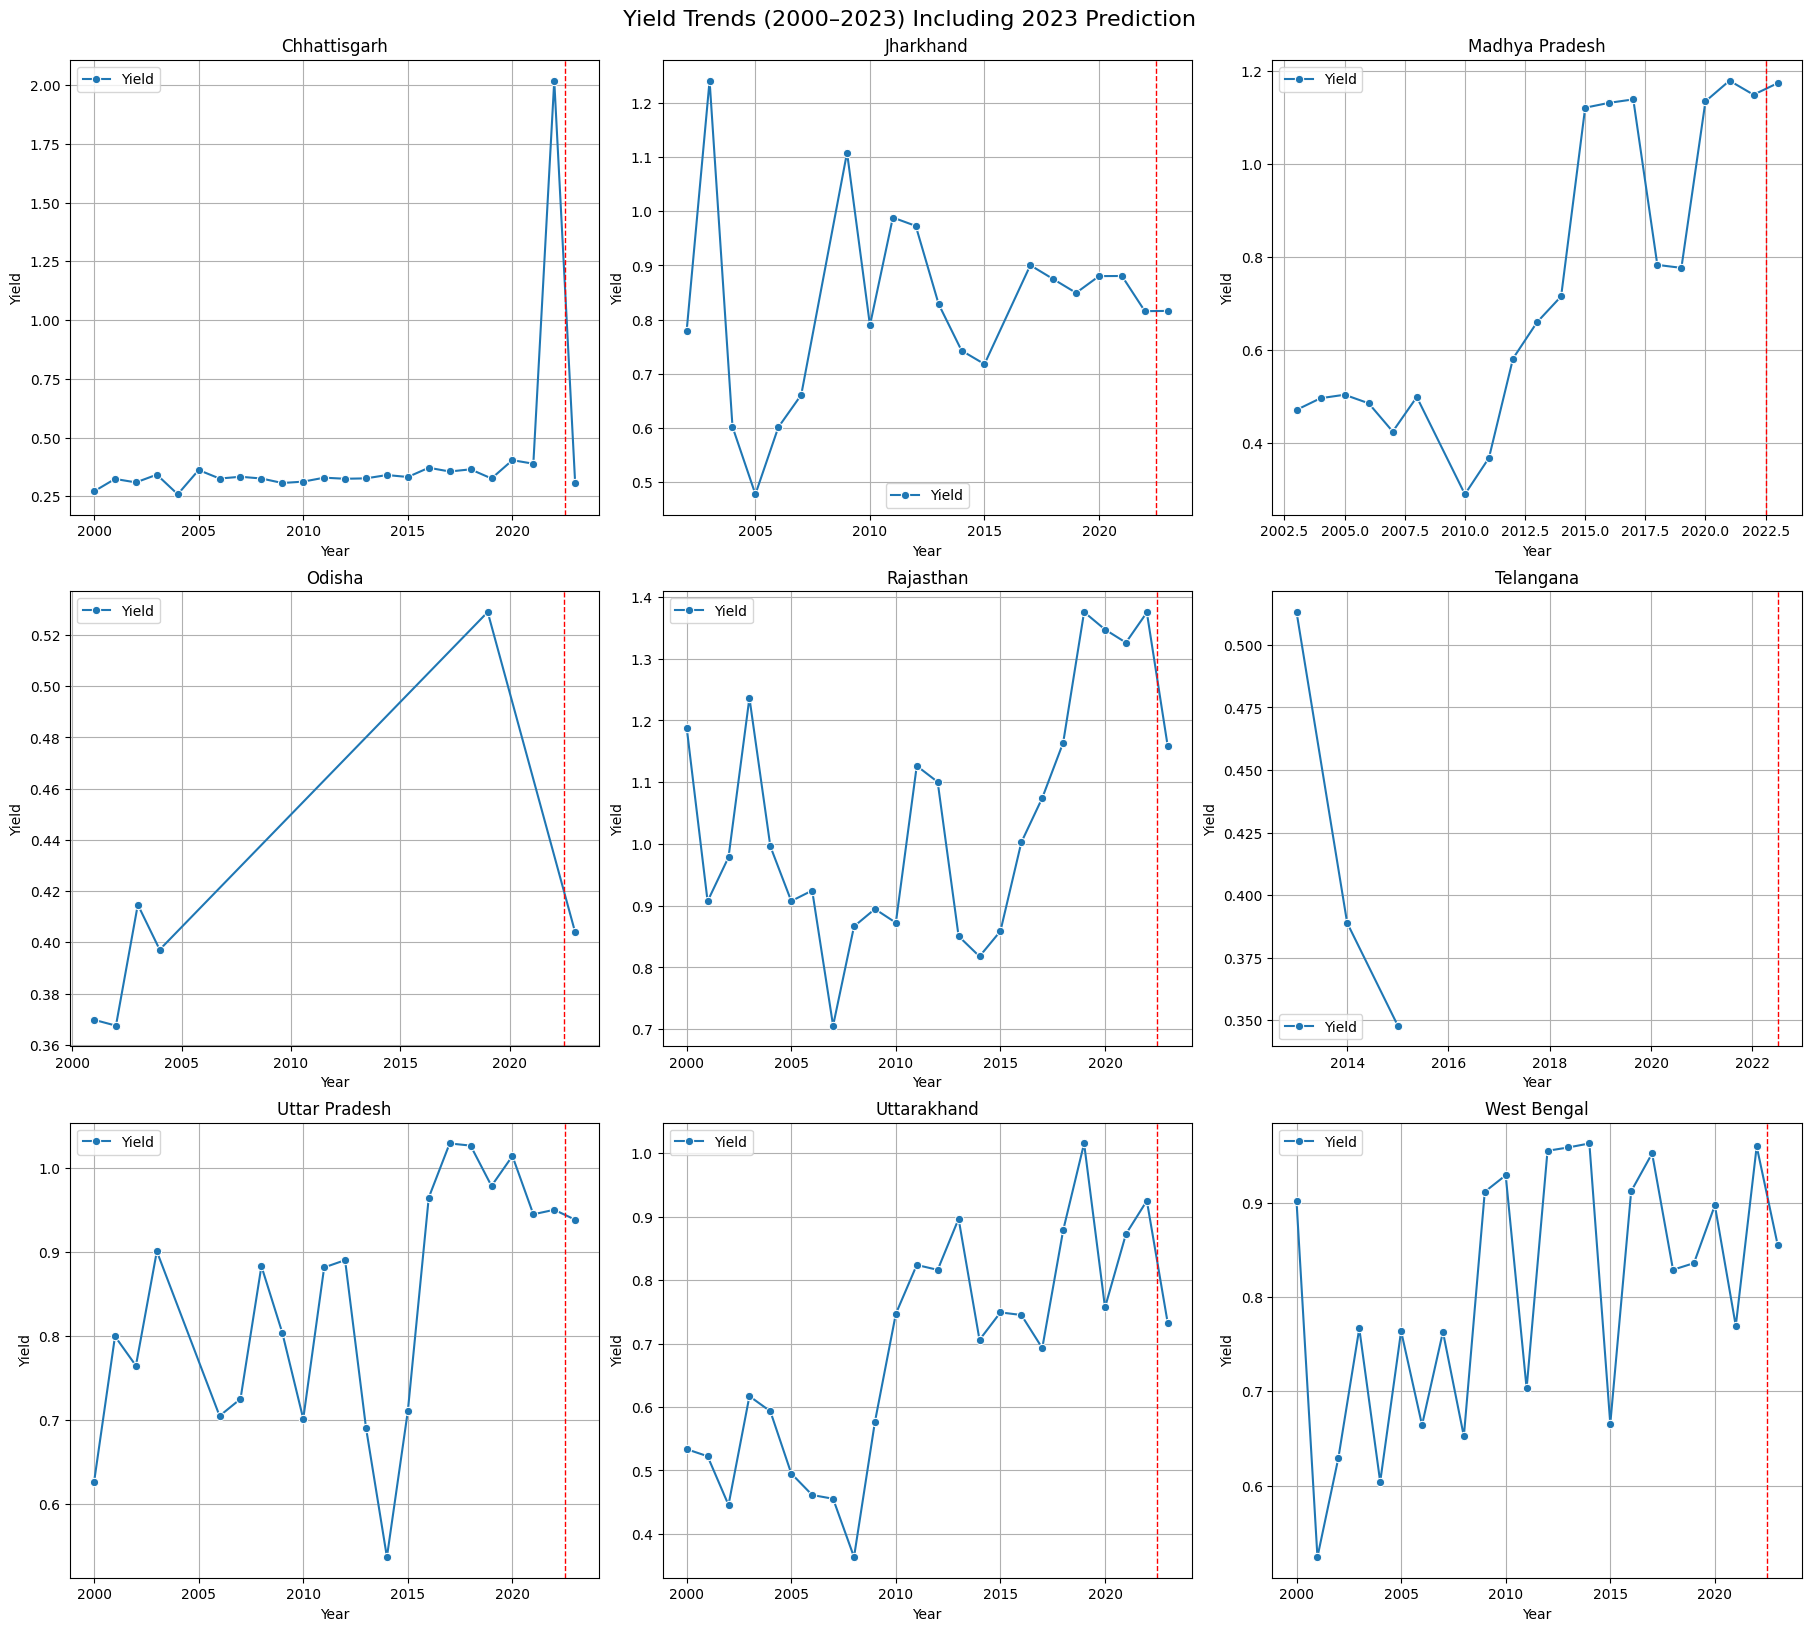

In [ ]:
# ==============================
# 8. Plot Actual vs Predicted Yield (2000–2023)
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns

# Combine historical yields with 2023 predictions
historical_yields = model_df[['state_name', 'year', 'yield']].rename(columns={'yield': 'actual_yield'})
preds_2023 = results_df[results_df['year'] == 2023][['state', 'year', 'predicted_yield']]
preds_2023 = preds_2023.rename(columns={'state': 'state_name'})

# Merge
plot_df = pd.merge(historical_yields, preds_2023, on=['state_name', 'year'], how='outer')
plot_df['yield_combined'] = plot_df['actual_yield'].combine_first(plot_df['predicted_yield'])

# Plot for each state
states = sorted(plot_df['state_name'].unique())
num_states = len(states)
fig, axes = plt.subplots(nrows=(num_states + 2) // 3, ncols=3, figsize=(18, num_states * 1.8), constrained_layout=True)

for i, state in enumerate(states):
    ax = axes[i // 3, i % 3]
    state_df = plot_df[plot_df['state_name'] == state].sort_values('year')

    sns.lineplot(data=state_df, x='year', y='yield_combined', marker='o', ax=ax, label='Yield')
    ax.axvline(x=2022.5, color='red', linestyle='--', lw=1)
    ax.set_title(state)
    ax.set_xlabel("Year")
    ax.set_ylabel("Yield")
    ax.grid(True)

# Hide empty subplots
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.suptitle(" Yield Trends (2000–2023) Including 2023 Prediction", fontsize=16)
plt.show()


